<a href="https://colab.research.google.com/github/ipavlopoulos/dfu/blob/main/DFU_CCTK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.metrics import *

In [2]:
%%capture
!pip install ktrain
import ktrain
from ktrain import text

In [3]:
%%capture
!git clone https://github.com/ipavlopoulos/dfu.git

In [4]:
train = pd.read_csv("dfu/cctk_train.countries.csv.gz", parse_dates=["created_at"])
train.country = train.country.apply(literal_eval)  
test = pd.read_csv("dfu/cctk_test.csv.gz", parse_dates=["created_at"])
dev = pd.read_csv("dfu/cctk_dev.csv.gz", parse_dates=["created_at"])
train.sample()

,created_at,text,scores,country
9112,2018-07-16 20:51:33,It's about as easy for a white person to notic...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[1, 6, 1, 1, 1, 5]"


Compute the average toxicity, st. dev., and DFU

In [5]:
from dfu.lib import to_hist, dfu
for dataset in (train, dev, test):
  dataset.scores = dataset.scores.apply(literal_eval)
  dataset.set_index("created_at", inplace=True)
  dataset["AVG"] = dataset.scores.apply(np.mean)
  dataset["STD"] = dataset.scores.apply(np.std)
  dataset["HIST"] = dataset.scores.apply(to_hist)
  dataset["DFU"] = dataset.HIST.apply(dfu)

## Exploratory
A unique integer represents each country name.

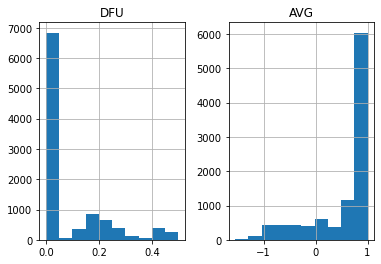

In [6]:
train.sort_values(by="created_at")[["DFU", "AVG"]].hist();

#### Exploring what happens in high-DFU texts.
* Do workers in high-DFU posts come from the same or other countries? 
* If country variation exists, are the poles across countries?
* Are polarised posts liked/disliked much? 
* Filter posts which are perceived differently across countries.

In [7]:
high_dfu = train[train.DFU==train.DFU.max()]
high_dfu.sample()

,text,scores,country,AVG,STD,HIST,DFU
created_at,,,,,,,
2018-07-16 20:29:16,"_""Re-Post #1 Someone didn’t like the word ‘vit...","[-1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -...","[1, 14, 11, 1, 6, 1, 1, 1, 1, 1]",0.0,1.0,"[0.5, 0.0, 0.5]",0.5


Workers who annotated these posts come from 38 different countries.


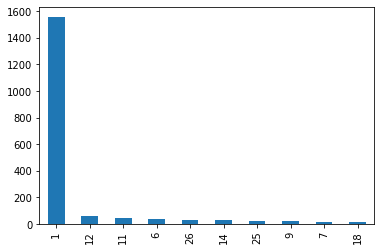

In [8]:
print(f"Workers who annotated these posts come from {len(high_dfu.country.explode().unique())} different countries.")
high_dfu.country.explode().value_counts()[:10].plot.bar();

Number of high-DFU posts for which the annotators came from the same country, compared to high-DFU posts for which they came from two.

In [9]:
c1_high_dfu = high_dfu[high_dfu.country.apply(lambda x: len(set(x))==1)]
c2_high_dfu = high_dfu[high_dfu.country.apply(lambda x: len(set(x))==2)]
print(f"In {c1_high_dfu.shape[0]} ({100*c1_high_dfu.shape[0]/high_dfu.shape[0]:.2f}%) posts all the annotators came from the same country, in {c2_high_dfu.shape[0]} ({100*c2_high_dfu.shape[0]/high_dfu.shape[0]:.2f}%) came from two; the rest had more.")

In 19 (9.55%) posts all the annotators came from the same country, in 42 (21.11%) came from two; the rest had more.


Posts with different perception across countries

In [ ]:
def cross_country_diff(countries, scores):
  dist_count = list(set(countries)) 
  assert len(dist_count)==2 # dim=2, always
  country_scores = {dist_count[0]:[], dist_count[1]:[]}
  for i in range(len(countries)):
    country_scores[countries[i]].append(scores[i])
  c1, c2 = np.mean(country_scores[dist_count[0]]), np.mean(country_scores[dist_count[1]])
  return max([c1,c2]) - min(c1,c2)

c2_high_dfu["cross_country_diff"] = c2_high_dfu.apply(lambda row: cross_country_diff(row.country, row.scores), 1)

In [13]:
c2_high_dfu.sort_values(by="cross_country_diff", ascending=False).head(5)

,text,scores,country,AVG,STD,HIST,DFU,cross_country_diff
created_at,,,,,,,,
2018-07-16 20:10:34,I'll second that. Ignorance is just lack of kn...,"[-1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -...","[12, 1, 1, 1, 1, 1, 1, 12, 1, 1]",0.0,1.0,"[0.5, 0.0, 0.5]",0.5,1.250000
2018-07-16 17:10:48,"She's married to an unindicted pedophile,,,","[1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -...","[1, 1, 12, 1, 1, 1, 1, 12, 1, 1]",0.0,1.0,"[0.5, 0.0, 0.5]",0.5,1.250000
2018-07-13 19:44:27,Why don't you stick with molesting women you s...,"[1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -...","[1, 1, 1, 1, 5, 1, 1, 1, 1, 1]",0.0,1.0,"[0.5, 0.0, 0.5]",0.5,1.111111
2018-07-16 20:34:48,If they did this they should be locked away fo...,"[1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, ...","[1, 32, 1, 1, 1, 1, 1, 1, 1, 1]",0.0,1.0,"[0.5, 0.0, 0.5]",0.5,1.111111
2018-07-16 20:36:50,Ridiculous the left has no credibility. And yo...,"[-1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1...","[1, 1, 1, 1, 1, 10, 1, 1, 1, 1]",0.0,1.0,"[0.5, 0.0, 0.5]",0.5,1.111111


#### Compute the number of distinct countries in high/low DFU posts

* Comparing the number of countries (of the annotators) in posts with high compared to low DFU.
* Repeating the measurement (1,000 times) on samples yields a st. significant result ($P<0.05$). 
* The same finding stands for larger samples, drawn from the whole dataset.

In [14]:
low, high = train.DFU.quantile(0.25), train.DFU.quantile(0.75)
trials = []
for i in range(1000):
  high_sample_cnum = train[train.DFU>high].sample(20).country.apply(set).apply(len).mean()
  low_sample_cnum = train[train.DFU<=low].sample(20).country.apply(set).apply(len).mean()
  trials.append(low_sample_cnum>high_sample_cnum)
print(f"P-value of {np.mean(trials)}")

P-value of 0.004


## Learning

### BERT
Training a BERT model on posts from a time window, then predicting DFU on ones posted later. 

In [ ]:
MODEL_NAME = 'bert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=128)
trn = t.preprocess_train(train.text.values, train.DFU.values)
val = t.preprocess_test(dev.text.values, dev.DFU.values)
model = t.get_regression_model()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=32)

preprocessing train...
language: en
train sequence lengths:
	mean : 53
	95percentile : 161
	99percentile : 179


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:723: UserWarning: Task is being treated as REGRESSION because either class_names argument was not supplied or is_regression=True. If this is incorrect, change accordingly.
  + "If this is incorrect, change accordingly."


preprocessing test...
language: en
test sequence lengths:
	mean : 56
	95percentile : 162
	99percentile : 179


simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
312/312 [==============================] - 262s 779ms/step - loss: 0.0464 - mae: 0.1776
Epoch 2/1024
312/312 [==============================] - 245s 785ms/step - loss: 0.0214 - mae: 0.1135
Epoch 3/1024
312/312 [==============================] - 245s 784ms/step - loss: 0.0179 - mae: 0.1018
Epoch 4/1024
312/312 [==============================] - 200s 642ms/step - loss: 1.9952 - mae: 0.2476


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


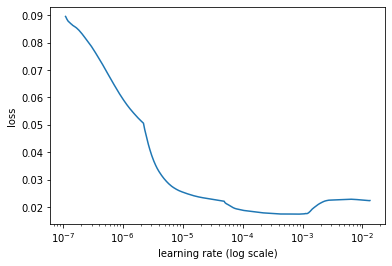

In [ ]:
learner.lr_find()
learner.lr_plot()

In [ ]:
learner.autofit(1e-4)
bert_dfu_model = ktrain.get_predictor(learner.model, t)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/1024
313/313 [==============================] - 349s 1s/step - loss: 0.0183 - mae: 0.1022 - val_loss: 0.0126 - val_mae: 0.0794
Epoch 2/1024
313/313 [==============================] - 329s 1s/step - loss: 0.0140 - mae: 0.0871 - val_loss: 0.0128 - val_mae: 0.0778
Epoch 3/1024
313/313 [==============================] - ETA: 0s - loss: 0.0120 - mae: 0.0784
Epoch 00003: Reducing Max LR on Plateau: new max lr will be 5e-05 (if not early_stopping).
313/313 [==============================] - 330s 1s/step - loss: 0.0120 - mae: 0.0784 - val_loss: 0.0136 - val_mae: 0.0791
Epoch 4/1024
313/313 [==============================] - 330s 1s/step - loss: 0.0074 - mae: 0.0592 - val_loss: 0.0152 - val_mae: 0.0796
Epoch 5/1024
313/313 [==============================] - ETA: 0s - loss: 0.0045 - mae: 0.0459
Epoch 00005

In [ ]:
bert_dfu_model.save("bert_dfu.mdl")

In [ ]:
preds = bert_dfu_model.predict(test.text.values)
print(f"BERT_DFU: {mean_absolute_error(test.DFU.values, preds):.4f}")

313/313 [==============================] - 87s 270ms/step
BERT_DFU: 0.0853


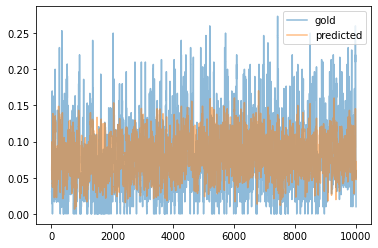

In [ ]:
pd.DataFrame({"gold":test.DFU.values, "predicted":preds}).rolling(10).mean().plot(alpha=0.5);

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Nov  4 16:23:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                  N/A |
| N/A   75C    P0    31W /  70W |   8672MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Using variance as learning objective


In [ ]:
MODEL_NAME = 'bert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=128)
trn = t.preprocess_train(train.text.values, train.STD.values)
val = t.preprocess_test(dev.text.values, dev.STD.values)
model = t.get_regression_model()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=32)

preprocessing train...
language: en
train sequence lengths:
	mean : 53
	95percentile : 161
	99percentile : 179


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:723: UserWarning: Task is being treated as REGRESSION because either class_names argument was not supplied or is_regression=True. If this is incorrect, change accordingly.
  + "If this is incorrect, change accordingly."


preprocessing test...
language: en
test sequence lengths:
	mean : 56
	95percentile : 162
	99percentile : 179


simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
312/312 [==============================] - 262s 778ms/step - loss: 0.2050 - mae: 0.3852
Epoch 2/1024
312/312 [==============================] - 244s 784ms/step - loss: 0.1387 - mae: 0.3065
Epoch 3/1024
312/312 [==============================] - 244s 782ms/step - loss: 0.1588 - mae: 0.3140
Epoch 4/1024
312/312 [==============================] - 221s 709ms/step - loss: 0.8405 - mae: 0.6566


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


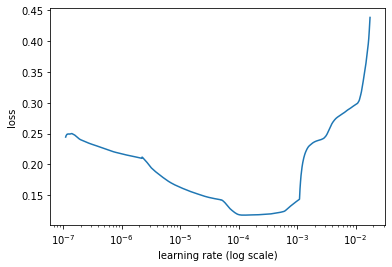

In [ ]:
learner.lr_find()
learner.lr_plot()

In [ ]:
learner.autofit(5e-5)
bert_std_model = ktrain.get_predictor(learner.model, t)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5e-05...
Epoch 1/1024
313/313 [==============================] - 349s 1s/step - loss: 0.1296 - mae: 0.2891 - val_loss: 0.0978 - val_mae: 0.2243
Epoch 2/1024
313/313 [==============================] - 329s 1s/step - loss: 0.0903 - mae: 0.2170 - val_loss: 0.1066 - val_mae: 0.2361
Epoch 3/1024
313/313 [==============================] - ETA: 0s - loss: 0.0674 - mae: 0.1753
Epoch 00003: Reducing Max LR on Plateau: new max lr will be 2.5e-05 (if not early_stopping).
313/313 [==============================] - 329s 1s/step - loss: 0.0674 - mae: 0.1753 - val_loss: 0.1066 - val_mae: 0.2108
Epoch 4/1024
313/313 [==============================] - 329s 1s/step - loss: 0.0424 - mae: 0.1286 - val_loss: 0.1099 - val_mae: 0.2059
Epoch 5/1024
313/313 [==============================] - ETA: 0s - loss: 0.0309 - mae: 0.1075
Epoch 0000

In [ ]:
preds = bert_std_model.predict(test.text.values)
print(f"BERT_STD: {mean_absolute_error(test.STD.values, preds):.4f}")

313/313 [==============================] - 89s 271ms/step
BERT_STD: 0.2332


### ML baselines

In [ ]:
text.print_text_regression_models()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
linreg: linear text regression using a trainable Embedding layer
bigru: Bidirectional GRU with pretrained English word vectors [https://arxiv.org/abs/1712.09405]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) - keras_bert implementation [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


In [ ]:
trn, val, preproc = text.texts_from_array(x_train=train.text.values, y_train=train.DFU.values,
                                          x_test=dev.text.values, y_test=dev.DFU.values,
                                          maxlen=128)

language: en
Word Counts: 28308
Nrows: 10000
10000 train sequences
train sequence lengths:
	mean : 53
	95percentile : 160
	99percentile : 179
x_train shape: (10000,128)
y_train shape: (10000,)


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:723: UserWarning: Task is being treated as REGRESSION because either class_names argument was not supplied or is_regression=True. If this is incorrect, change accordingly.
  + "If this is incorrect, change accordingly."


10000 test sequences
test sequence lengths:
	mean : 55
	95percentile : 159
	99percentile : 175
x_test shape: (10000,128)
y_test shape: (10000,)
task: text regression (supply class_names argument if this is supposed to be classification task)


#### Bidirectional GRU

In [ ]:
MODEL_NAME = "bigru"
b1 = text.text_regression_model(MODEL_NAME, train_data=trn, preproc=preproc)
b1_learner = ktrain.get_learner(b1, train_data=trn, val_data=val, batch_size=32)

maxlen is 128
word vectors will be loaded from: https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
processing pretrained word vectors...
loading pretrained word vectors...this may take a few moments...


done.


simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
313/313 [==============================] - 11s 16ms/step - loss: 0.0247 - mae: 0.1336
Epoch 2/1024
313/313 [==============================] - 5s 16ms/step - loss: 0.0212 - mae: 0.1143
Epoch 3/1024
313/313 [==============================] - 5s 16ms/step - loss: 0.0184 - mae: 0.1046
Epoch 4/1024
313/313 [==============================] - 5s 16ms/step - loss: 0.0181 - mae: 0.1025
Epoch 5/1024
313/313 [==============================] - 0s 919us/step - loss: 2.2439 - mae: 0.5635


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


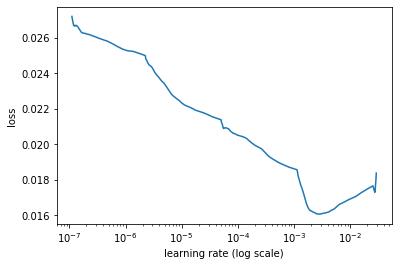

In [ ]:
b1_learner.lr_find()
b1_learner.lr_plot()

In [ ]:
b1_learner.autofit(1e-3)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Epoch 1/1024
313/313 [==============================] - 10s 23ms/step - loss: 0.0191 - mae: 0.1055 - val_loss: 0.0148 - val_mae: 0.0894
Epoch 2/1024
313/313 [==============================] - 7s 21ms/step - loss: 0.0136 - mae: 0.0872 - val_loss: 0.0146 - val_mae: 0.0894
Epoch 3/1024
313/313 [==============================] - 7s 21ms/step - loss: 0.0100 - mae: 0.0741 - val_loss: 0.0153 - val_mae: 0.0951
Epoch 4/1024
313/313 [==============================] - ETA: 0s - loss: 0.0073 - mae: 0.0636
Epoch 00004: Reducing Max LR on Plateau: new max lr will be 0.0005 (if not early_stopping).
313/313 [==============================] - 7s 21ms/step - loss: 0.0073 - mae: 0.0636 - val_loss: 0.0159 - val_mae: 0.0977
Epoch 5/1024
313/313 [==============================] - 7s 21ms/step - loss: 0.0048 - mae: 0.0515 - val

In [ ]:
from sklearn.metrics import *
b1_predictor = ktrain.get_predictor(b1_learner.model, preproc)
preds = b1_predictor.predict(test.text.values)
print(f"BiGRU_DFU: {mean_absolute_error(test.DFU.values, preds):.4f}")

313/313 [==============================] - 2s 5ms/step
BiGRU_DFU: 0.0955


#### Linear Regression with trainable embeddings

In [ ]:
MODEL_NAME = "linreg"
b2 = text.text_regression_model(MODEL_NAME, train_data=trn, preproc=preproc)
b2_learner = ktrain.get_learner(b2, train_data=trn, val_data=val, batch_size=32)

maxlen is 128
done.


simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
313/313 [==============================] - 1s 3ms/step - loss: 0.0267 - mae: 0.1151
Epoch 2/1024
313/313 [==============================] - 1s 3ms/step - loss: 0.0263 - mae: 0.1143
Epoch 3/1024
313/313 [==============================] - 1s 3ms/step - loss: 0.0223 - mae: 0.1045
Epoch 4/1024
313/313 [==============================] - 1s 3ms/step - loss: 0.1562 - mae: 0.2140


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


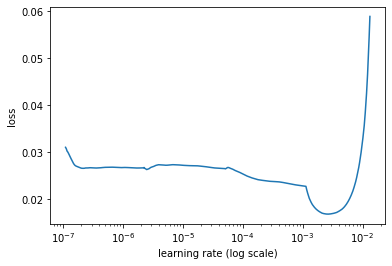

In [ ]:
b2_learner.lr_find()
b2_learner.lr_plot()

In [ ]:
b2_learner.autofit(1e-3)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Epoch 1/1024
313/313 [==============================] - 2s 6ms/step - loss: 0.0226 - mae: 0.1057 - val_loss: 0.0194 - val_mae: 0.0987
Epoch 2/1024
313/313 [==============================] - 2s 6ms/step - loss: 0.0148 - mae: 0.0845 - val_loss: 0.0196 - val_mae: 0.0987
Epoch 3/1024
303/313 [============================>.] - ETA: 0s - loss: 0.0116 - mae: 0.0734
Epoch 00003: Reducing Max LR on Plateau: new max lr will be 0.0005 (if not early_stopping).
313/313 [==============================] - 2s 7ms/step - loss: 0.0117 - mae: 0.0737 - val_loss: 0.0206 - val_mae: 0.1025
Epoch 4/1024
313/313 [==============================] - 2s 6ms/step - loss: 0.0094 - mae: 0.0644 - val_loss: 0.0208 - val_mae: 0.1036
Epoch 5/1024
302/313 [===========================>..] - ETA: 0s - loss: 0.0079 - mae: 0.0575
Epoch 00005: Re

In [ ]:
b2_predictor = ktrain.get_predictor(b2_learner.model, preproc)
preds = b2_predictor.predict(test.text.values)
print(f"LinReg_DFU: {mean_absolute_error(test.DFU.values, preds):.4f}")

313/313 [==============================] - 0s 1ms/step
LinReg_DFU: 0.1022


#### FastText

In [ ]:
MODEL_NAME = "fasttext"
b3 = text.text_regression_model(MODEL_NAME, train_data=trn, preproc=preproc)
b3_learner = ktrain.get_learner(b3, train_data=trn, val_data=val, batch_size=32)

maxlen is 128
done.


simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
313/313 [==============================] - 2s 4ms/step - loss: 1.6781 - mae: 1.0214
Epoch 2/1024
313/313 [==============================] - 1s 4ms/step - loss: 1.6115 - mae: 0.9971
Epoch 3/1024
313/313 [==============================] - 1s 4ms/step - loss: 1.0227 - mae: 0.7850
Epoch 4/1024
313/313 [==============================] - 1s 5ms/step - loss: 0.1937 - mae: 0.3080
Epoch 5/1024
313/313 [==============================] - 2s 5ms/step - loss: 0.0224 - mae: 0.1153
Epoch 6/1024
313/313 [==============================] - 1s 4ms/step - loss: 0.0243 - mae: 0.1231


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


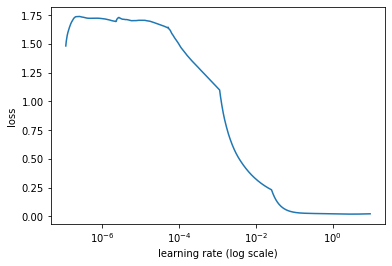

In [ ]:
b3_learner.lr_find()
b3_learner.lr_plot()

In [ ]:
b3_learner.autofit(1e-2)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.01...
Epoch 1/1024
313/313 [==============================] - 3s 7ms/step - loss: 0.2098 - mae: 0.2705 - val_loss: 0.0178 - val_mae: 0.0887
Epoch 2/1024
313/313 [==============================] - 2s 7ms/step - loss: 0.0187 - mae: 0.1069 - val_loss: 0.0166 - val_mae: 0.1025
Epoch 3/1024
313/313 [==============================] - 2s 7ms/step - loss: 0.0187 - mae: 0.1074 - val_loss: 0.0165 - val_mae: 0.1020
Epoch 4/1024
313/313 [==============================] - 2s 7ms/step - loss: 0.0183 - mae: 0.1063 - val_loss: 0.0162 - val_mae: 0.1008
Epoch 5/1024
313/313 [==============================] - 2s 7ms/step - loss: 0.0180 - mae: 0.1049 - val_loss: 0.0161 - val_mae: 0.1013
Epoch 6/1024
313/313 [==============================] - 2s 7ms/step - loss: 0.0175 - mae: 0.1018 - val_loss: 0.0159 - val_mae: 0.0993
Epoch 7/1024


In [ ]:
b3_predictor = ktrain.get_predictor(b3_learner.model, preproc)
preds = b3_predictor.predict(test.text.values)
print(f"FastText_DFU: {mean_absolute_error(test.DFU.values, preds):.4f}")

313/313 [==============================] - 0s 1ms/step
FastText_DFU: 0.0985
